Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

import csv
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D, Dense
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# setting random seeds to reduce the amount of randomness in the neural net weights and results

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import files

uploaded = files.upload()

Saving age_model.h5 to age_model.h5
Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml
Saving train.zip to train.zip
Saving train_csv.csv to train_csv.csv
Saving val.zip to val.zip
Saving val_csv.csv to val_csv.csv


In [8]:
!unzip val.zip

Archive:  val.zip
   creating: val/
  inflating: val/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg  
  inflating: val/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg  
  inflating: val/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTEODAOTcxNjcMjczMjkzjpg.jpg  
  inflating: val/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg  
  inflating: val/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIwNjANjMMDINzIxNjcjpg.jpg  
  inflating: val/httpassetsrollingstonecomassetsarticlemadonnadavidbowiechangedthecourseofmylifeforeversmallsquarexmadonnabowiejpg.jpg  
  inflating: val/httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg  
  inflating: val/httpaurorasblogcomwpcontentuploadsjerryseinfeldpublicityshotjpg.jpg  
  inflating: val/httpblognjcomentertainmentimpactcelebritiesmediumjerrybjpg.jpg  
  inflating: val/httpbpblogspotcomedLMjVpRGkSWexgsXjkNIAAAAAAAADWgFFtAUqBlhAsjpg.jpg  
  

In [9]:
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/httpcsvkmeuaeccjpg.jpg  
  inflating: train/httpftqncomymusicLxZeltonjohnjpg.jpg  
  inflating: train/httpgonetworthcomwpcontentuploadsthumbsjpg.jpg  
  inflating: train/httpgraphicsnytimescomimagesmagazinekalingkalingarticleInlinejpg.jpg  
  inflating: train/httpgraphicsnytimescomimagessectionmoviesfilmographyWireImagejpg.jpg  
  inflating: train/httpiamediaimdbcomimagesMMVBMTANDQNTAxNDVeQTJeQWpwZBbWUMDIMjQOTYVUXCRALjpg.jpg  
  inflating: train/httpiamediaimdbcomimagesMMVBMTAxNDUMzUwOTdeQTJeQWpwZBbWUMDUOTAyNTIVUXCRALjpg.jpg  
  inflating: train/httpikinjaimgcomgawkermediaimageuploadsWmIuhdsrcedidjpgjpg.jpg  
  inflating: train/httpimagegaladevcmseamadonnaprivatdetektivsquaretopsquarejpgv.jpg  
  inflating: train/httpimagescontactmusiccomnewsimagesjerryseinfeldjpg.jpg  
  inflating: train/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: train/ht

Ovaj kod definiše funkciju nazvanu class_labels_reassign koja uzima ulazni parametar age i vraća celobrojnu vrednost na osnovu datog opsega uzrasta.

In [10]:
def class_labels_reassign(age):
  if age == '0-14':
    return 0
  if age == '15-24':
    return 1
  if age == '25-64':
    return 2
  if age == '65-100':
    return 3

Čitanje sadržaja CSV datoteke, informacije o uzrastu iz svakog reda JSON fajla

In [11]:
ages = [] # list to store age labels

with open('/content/val_csv.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        line_count += 1
      else:
        rowJson = json.loads(row[6])
        ages.append(rowJson["age"])
        line_count += 1

Priprema testnih slika i odgovarajućih oznaka radi evaluacije modela za klasifikaciju

In [12]:
path = '/content/val' # path to the directory with test images
x_test = [] # images
y_test = [] # labels

i = 0
for img in os.listdir(path):
  i = i + 1
  img = cv2.imread(str(path) + '/' + str(img))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray scale
  img = cv2.resize(img, (100, 100))
  x_test.append(np.array(img))
  y_test.append(np.array(class_labels_reassign(ages[i - 1])))

x_test = np.array(x_test) # convert the list of image arrays to a numpy array
y_test = np.array(y_test, np.uint64) # convert the list of labels to a numpy array of uint64 type

Čitanje CSV fajla, ovaj put trening podataka

In [13]:
ages = [] # list to store age labels

with open('/content/train_csv.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        line_count += 1
      else:
        rowJson = json.loads(row[6])
        ages.append(rowJson["age"])
        line_count += 1

Obrada i priprema trening slika i odgovarajućih oznaka za pripremu u modelu

In [14]:
path = '/content/train'
x_train = [] # images
y_train = [] # labels

i = 0
for img in os.listdir(path):
  i = i + 1
  img = cv2.imread(str(path) + '/' + str(img))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
  img = cv2.resize(img, (100, 100))
  x_train.append(np.array(img))
  y_train.append(np.array(class_labels_reassign(ages[i - 1])))

x_train = np.array(x_train) # convert the list of image arrays to a numpy array
y_train = np.array(y_train, np.uint64) # convert the list of labels to a numpy array of uint64 type

Arhitektura konvolucijske neuronske mreže za klasifikaciju

In [15]:
input = Input(shape = (100,100,1)) # define the input shape for the model - indicating that the input images are grayscale with dimensions 100x100

# convolutional layers (conv1, conv2, conv3, conv4 with 32, 64, 128, and 256 filters, respectively) with dropout and activation
conv1 = Conv2D(32, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4) # flatten the output of the last convolutional layer

dense_1 = Dense(128, activation='relu')(flatten) # fully connected layer with ReLU activation

drop_1 = Dropout(0.2)(dense_1) # dropout layer - to prevent overfitting

output = Dense(4, activation="sigmoid")(drop_1) # output layer, 4 - number of possible outputs

In [16]:
model = Model(inputs=input,outputs=output) # create a model by specifying the input and output layers
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy']) # compile the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [17]:
model_path = './output/age_model.h5' # path where the model will be saved
# sets the metric to monitor for saving the best model, saves only the best model based on the monitored metric, the entire model will be saved
checkpointer = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only = True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list = [checkpointer]

Treniranje modela

In [18]:
save = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[callback_list])

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 14.2022 - accuracy: 0.6333
Epoch 1: loss improved from inf to 14.20219, saving model to ./output/age_model.h5
3/3 [==============================] - 5s 1s/step - loss: 14.2022 - accuracy: 0.6333 - val_loss: 35.2011 - val_accuracy: 0.7200
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 5.1987 - accuracy: 0.8444
Epoch 2: loss improved from 14.20219 to 5.19868, saving model to ./output/age_model.h5
3/3 [==============================] - 2s 633ms/step - loss: 5.1987 - accuracy: 0.8444 - val_loss: 26.7857 - val_accuracy: 0.7200
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 4.6239 - accuracy: 0.9444
Epoch 3: loss improved from 5.19868 to 4.62391, saving model to ./output/age_model.h5
3/3 [==============================] - 2s 615ms/step - loss: 4.6239 - accuracy: 0.9444 - val_loss: 15.7308 - val_accuracy: 0.7200
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 2.1953 - accuracy: 0.9444
Epoch 4: loss improved from 4.62391 to 2.19529, saving model to ./output/age_model.h5
3/3 [==============================] - 2s 604ms/step - loss: 2.1953 - accuracy: 0.9444 - val_loss: 5.5061 - val_accuracy: 0.7200
Epoch 5/30
3/3 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.

Čuvanje gubitka i tačnosti

In [19]:
# checking the train and test loss and accuracy values from the neural network above

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Iscrtavanje grafikona

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

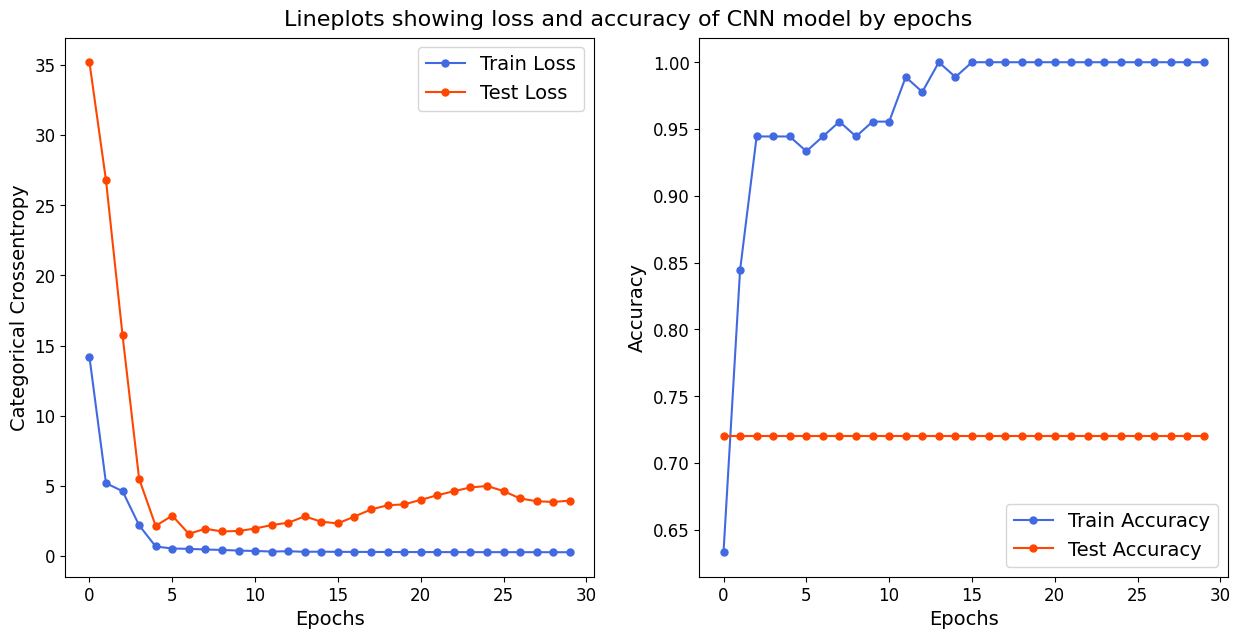

In [20]:
# plotting a line chart to visualize the loss and accuracy values by epochs

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

Evaluacija modela

In [21]:
# Evaluate the gender model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')

1/1 [==============================] - 0s 171ms/step - loss: 3.9500 - accuracy: 0.7200
Test Loss: 3.95
Test Accuracy: 0.72
